# Finding the best consultant

You work for McKeen Sea, a consulting firm. One of McKeen Sea's most important customers has requested an additional consultant, and you've been tasked to find the best one available out of two potential candidates: Aaron and Ben. Fortunately, McKeen Sea has collected some data on the past performance of these consultants, and so you would like to use the data to make a better decision. 

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append("..")


! git clone https://github.com/yizuc/datamining.git


In [ ]:
from datamining.ds_utils.sample_data import get_project_data


data = get_project_data()
data.head()

In [ ]:
data.Consultant.value_counts()

In [ ]:
# Some auxiliar functions for plotting
def plot_avg_performance(data, groups=None):
    plot_auxiliar(data, groups, True)
    
def plot_number_of_projects(data, groups=None):
    plot_auxiliar(data, groups, False)

def plot_auxiliar(data, groups, mean=True):
    if groups is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
        if mean:
            data.groupby(['Consultant']).Performance.mean().plot(kind='bar', rot=0, ax=ax)
            plt.ylabel('Avg. performance')
            plt.ylim((0, 1))
        else:
            data.groupby(['Consultant']).Performance.size().plot(kind='bar', rot=0, ax=ax)
            plt.ylabel('# of projects')
    else:
        grouped = data.groupby(groups)
        rows = int(grouped.ngroups/2)
        fig, axs = plt.subplots(figsize=(16,7*rows), nrows=rows, ncols=2, gridspec_kw=dict(hspace=0.4))
        targets = zip(grouped.groups.keys(), axs.flatten())
        for i, (key, ax) in enumerate(targets):
            if mean:
                grouped.get_group(key).groupby('Consultant').Performance.mean().plot(kind='bar', rot=0, ax=ax)
                ax.set_ylabel('Avg. performance')
                ax.set_ylim((0, 1))
            else:
                grouped.get_group(key).groupby('Consultant').Performance.size().plot(kind='bar', rot=0, ax=ax)
                ax.set_ylabel('# of projects')
            key_s = []
            if type(key) is not tuple:
                key = (key,)
            for j, elem in enumerate(key):
                key_s.append(elem + ' ' +  groups[j])
            ax.set_title(' | '.join(key_s))

plot_avg_performance(data)

Would this information be useful to assess if Aaron will perform better than Ben? What happens if we split the data by customer?

In [ ]:
plot_avg_performance(data, groups=['Customer'])

Ben performs better than Aaron, both with new AND old customers! How can this be possible? 

In [ ]:
plot_number_of_projects(data, groups=['Customer'])

While Ben has been working mostly with new customers, Aaron has been working mostly with old customers. To the extent that projects with new customers are more difficult, it makes sense for Ben to have a lower average performance. After all, he's been managing more difficult projects. However, once we account for customer type, we can see that Ben had better performance dealing with both types of customers. 

So, who do you think will perform better? Do you feel more confident with your answer?

Before making a final decision, let's split by project size as well.

In [ ]:
plot_avg_performance(data, groups=['Customer', 'Project'])

The tides have turned again! Aaron now performs the same or better in all categories. Why?

In [ ]:
plot_number_of_projects(data, groups=['Customer', 'Project'])

Confounding bias once more. Despite working with older customers, Aaron is also working in larger projects. We can see in earlier graphs that larger projects are more difficult (performance is lower), explaining Aaron's lower performance in other graphs. However, once we account for that in our analysis, we can see that Aaron's average performance is better across all categories.

So... Do you think we should go about assessing the performance of these consultants? Can we tell which consultant is better using this data set?

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

Not without making additional assumptions about the world! Namely, we would have to assume that there is no other omitted variable influencing both performance and project assignment (such as customer type or project size in the earlier examples). If we cannot make this "no-confounding" assumption, then we cannot be certain of whether the difference in performance is due to the consultants or ommited variable(s). Unfortunately, this is an assumption that we cannot test with data, which is the main reason why causal inference tends to be so challenging: it is hard to tell whether we are comparing apples with apples here. That being said, very often we still need to make a decision (as in this case), regardless of whether our assumptions are justified. And so, even though our assumptions might be violated, Aaron seems like the more reasonable option.

In this particular example, however, there is another variable excluded from our analysis: service type. By including this variable, we can see that both consultants perform the same across all types of projects, and so all differences in performance were driven by factors influencing both performance and project assignment. 

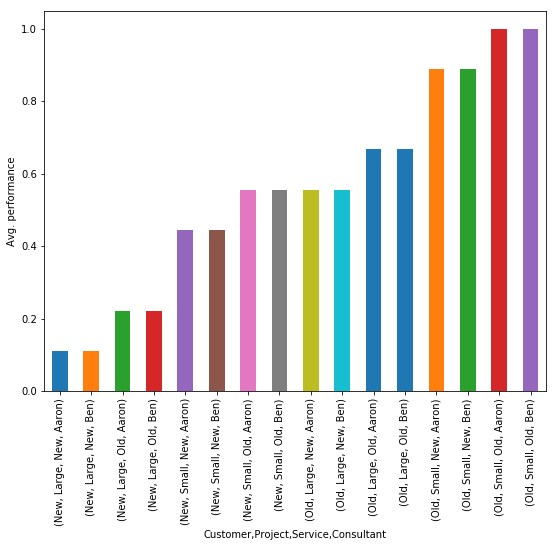

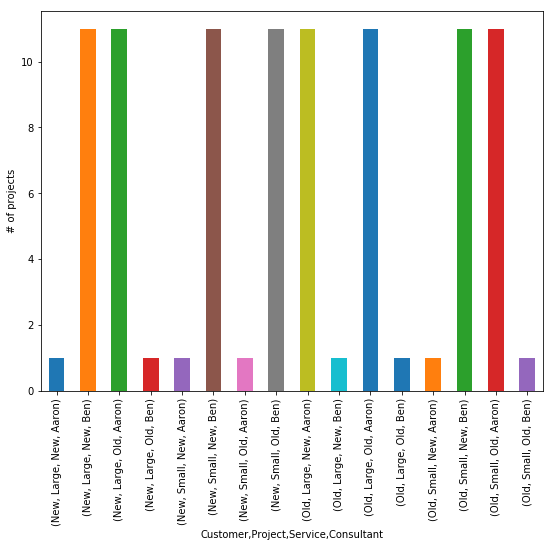

In [ ]:
plt.rcParams['figure.figsize'] = [9, 7]
data.groupby(['Customer', 'Project', 'Service', 'Consultant']).Performance.mean().plot(kind='bar')
plt.ylabel('Avg. performance')
plt.show()
plt.rcParams['figure.figsize'] = [9, 7]
data.groupby(['Customer', 'Project', 'Service', 'Consultant']).Performance.size().plot(kind='bar')
plt.ylabel('# of projects')
plt.show()

This is an example of Simpson's paradox. Simpson’s paradox refers to a phenomena whereby the association between a pair of  variables (X, Y) reverses sign upon conditioning of a third variable, Z, regardless of the value taken by Z. If we partition the data into subpopulations, each representing a specific value of the third variable, the phenomena appears as a sign reversal between the associations measured in the disaggregated subpopulations relative to the aggregated data, which describes the population as a whole. For a more graphical explanation, take a look at the following image:

![Image of Yaktocat](https://github.com/yizuc/datamining/blob/master/Module8_Causality/paradox.jpeg?raw=1)

One thing we can do to circument this issue is to compare projects that are very similar to each other but that differ only on the consultant that they were assigned. This is called *matching* and we can do that using some of the tools we studied in the previous class, such as nearest neighbors.

In [ ]:
from sklearn.neighbors import NearestNeighbors

dummy_data = pd.get_dummies(data=data, drop_first=True)
aaron_obs = dummy_data[dummy_data.Consultant_Ben != 1]
ben_obs = dummy_data[dummy_data.Consultant_Ben == 1]
aaron_obs = aaron_obs.drop('Consultant_Ben', axis='columns')
ben_obs = ben_obs.drop('Consultant_Ben', axis='columns')

nbrs = NearestNeighbors(n_neighbors=1).fit(aaron_obs)
distances, indices = nbrs.kneighbors(ben_obs)
matched_obs = aaron_obs.iloc[indices.reshape(-1)]
print("Ben Projects")
print(ben_obs.mean())
print("Aaron's (matched) projects")
print(matched_obs.mean())
print("Aaron's (unmatched) projects")
print(aaron_obs.mean())

Ben Projects
Performance      0.509259
Customer_Old     0.291667
Project_Small    0.708333
Service_Old      0.291667
dtype: float64
Aaron's (matched) projects
Performance      0.509259
Customer_Old     0.291667
Project_Small    0.708333
Service_Old      0.291667
dtype: float64
Aaron's (unmatched) projects
Performance      0.601852
Customer_Old     0.708333
Project_Small    0.291667
Service_Old      0.708333
dtype: float64
